# CBOW
连续词袋模型

## 准备数据

In [1]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

In [2]:
def create_cbow_dataset(sentences,windows_size=2):
    data = []
    for sentence in sentences:
        splited_sentence = sentence.split() # 分词
        for idx,word in enumerate(splited_sentence):
            context_words = splited_sentence[max(idx-windows_size,0):idx] \
            + splited_sentence[idx+1:min(idx+windows_size,len(splited_sentence))] #注意换行符
            data.append((word,context_words))
    return data

sentences = [
    "Cat is animal",
    "Dog is animal",
    "Lion is animal",
    "Bear is animal",
    "Merlin is bird",
    "Pidgen is bird",
    "Cat can run",
    "Dog can run",
    "Lion can run",
    "Merlin can fly",
    "Pidgen can fly",
    "Cat eats fish",
    "Dog eats bone",
    "Lion eats meat",
    "Bear eats fish and meat",
    "Merlin eats meat",
    "Pidgen eats seeds"
]

cbow_data = create_cbow_dataset(sentences)

pp.pprint(cbow_data)

[   ('Cat', ['is']),
    ('is', ['Cat', 'animal']),
    ('animal', ['Cat', 'is']),
    ('Dog', ['is']),
    ('is', ['Dog', 'animal']),
    ('animal', ['Dog', 'is']),
    ('Lion', ['is']),
    ('is', ['Lion', 'animal']),
    ('animal', ['Lion', 'is']),
    ('Bear', ['is']),
    ('is', ['Bear', 'animal']),
    ('animal', ['Bear', 'is']),
    ('Merlin', ['is']),
    ('is', ['Merlin', 'bird']),
    ('bird', ['Merlin', 'is']),
    ('Pidgen', ['is']),
    ('is', ['Pidgen', 'bird']),
    ('bird', ['Pidgen', 'is']),
    ('Cat', ['can']),
    ('can', ['Cat', 'run']),
    ('run', ['Cat', 'can']),
    ('Dog', ['can']),
    ('can', ['Dog', 'run']),
    ('run', ['Dog', 'can']),
    ('Lion', ['can']),
    ('can', ['Lion', 'run']),
    ('run', ['Lion', 'can']),
    ('Merlin', ['can']),
    ('can', ['Merlin', 'fly']),
    ('fly', ['Merlin', 'can']),
    ('Pidgen', ['can']),
    ('can', ['Pidgen', 'fly']),
    ('fly', ['Pidgen', 'can']),
    ('Cat', ['eats']),
    ('eats', ['Cat', 'fish']),
    ('fish'

## 定义模型

In [3]:
import torch
import torch.nn as nn

class Cbow(nn.Module):
    def __init__(self,voc_size,embedding_size):
        super(Cbow,self).__init__()
        self.input_to_hidden = nn.Linear(voc_size,embedding_size,bias=False)
        self.hidden_to_output = nn.Linear(embedding_size,voc_size,bias=False)
    
    def forward(self,X):
        embeddings = self.input_to_hidden(X)
        hidden = torch.mean(embeddings,dim=0)
        output = self.hidden_to_output(hidden.unsqueeze(0))
        return output
    
words = list(set(' '.join(sentences).split()))
word_to_idx = {word:idx for idx,word in enumerate(words)}
voc_size = len(word_to_idx)
embedding_size = 2

cbow_model = Cbow(voc_size=voc_size,embedding_size=embedding_size)

print(cbow_model)

Cbow(
  (input_to_hidden): Linear(in_features=18, out_features=2, bias=False)
  (hidden_to_output): Linear(in_features=2, out_features=18, bias=False)
)


d:\Middlewares\anaconda3\envs\torch3d\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def one_hot_encoding(word,word_to_idx):
    tensor = torch.zeros(len(word_to_idx))
    tensor[word_to_idx[word]] = 1
    return tensor

## 训练

Epoch:100,Loss:2.8637094902542404
Epoch:200,Loss:2.8357070257078925
Epoch:300,Loss:2.796862062418236
Epoch:400,Loss:2.740868347995686
Epoch:500,Loss:2.662754825825961
Epoch:600,Loss:2.5639832177252138
Epoch:700,Loss:2.4563307829622953
Epoch:800,Loss:2.352381081513639
Epoch:900,Loss:2.2555871144780575
Epoch:1000,Loss:2.1643954920318893


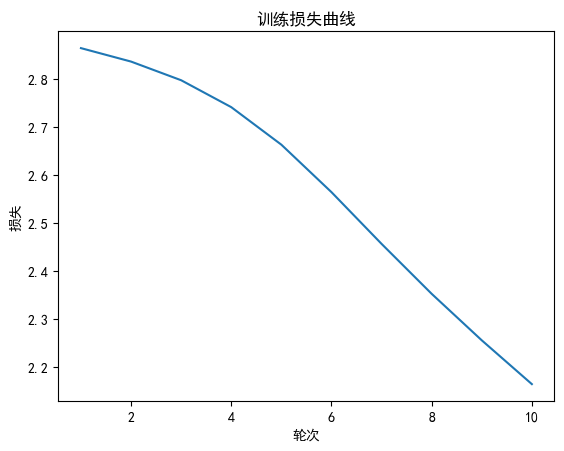

In [5]:
import torch.optim as optim

learning_rate = 0.001
epochs = 1000
criterion = nn.CrossEntropyLoss()
optimzier = optim.SGD(cbow_model.parameters(),lr=learning_rate)

loss_values = []

for epoch in range(epochs):
    loss_sum = 0
    for word,context in cbow_data:
        X = torch.stack([one_hot_encoding(w,word_to_idx) for w in context]).float()
        y_pred = cbow_model(X)
        y_true = torch.tensor([word_to_idx[word]],dtype=torch.long)
        loss = criterion(y_pred,y_true)
        loss_sum += loss.item()
        optimzier.zero_grad() #清空梯度
        loss.backward() # 反向传播
        optimzier.step() # 更新参数
    if (epoch+1) % 100 == 0:
        print(f"Epoch:{epoch+1},Loss:{loss_sum/len(cbow_data)}")
        loss_values.append(loss_sum/len(cbow_data))

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = ["SimHei"]
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False
plt.plot(range(1, epochs // 100 + 1), loss_values)
plt.title("训练损失曲线")
plt.xlabel("轮次")
plt.ylabel("损失")
plt.show()

## 查看词向量

In [6]:
weights = cbow_model.input_to_hidden.weight.cpu().detach().numpy()
pp.pprint(weights)

array([[-0.4976988 ,  0.4738096 , -0.07601008,  0.18034482,  1.0550615 ,
        -0.25921386,  0.22994073,  0.55606914, -0.69391507,  0.6684929 ,
        -0.39855686,  0.8471475 , -0.32237044, -0.650691  , -0.20178877,
         0.41995785, -0.392826  ,  0.08957649],
       [ 1.0983595 , -0.3720835 , -0.9726168 , -0.70189756, -1.8977712 ,
        -0.9149052 , -1.1555866 , -1.3297168 , -0.20373106, -0.04554418,
        -1.262083  ,  0.34060723, -0.36322588, -0.61679226, -0.16464034,
         0.09708661,  1.3044027 ,  1.2871321 ]], dtype=float32)


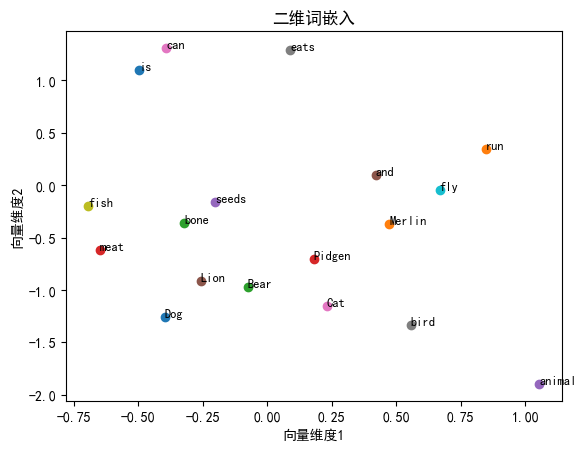

In [7]:
fig,ax = plt.subplots()
for word,idx in word_to_idx.items():
    vec = cbow_model.input_to_hidden.weight[:,idx].detach().numpy()
    ax.scatter(vec[0],vec[1])
    ax.annotate(word,(vec[0],vec[1]),fontsize=9)
plt.title('二维词嵌入')
plt.xlabel('向量维度1')
plt.ylabel('向量维度2')
plt.show()